# Data Preprocessing

## 0. Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import cv2 as cv
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. Load dataset

In [5]:
dire = '/home/sbml/cgan/BMSdata/'

file_list = os.listdir(dire)
file_list = list(sorted(file_list))[1:]

df_list = []
for i in range(len(file_list)):
    d = pd.read_csv(dire + file_list[i])
    df_list.append(d)

In [7]:
df = pd.concat(df_list)
col = df.columns.tolist()
df = df[col[:-13]]

df.columns = ['Time', 'voltage [V]', 'current [A]', 'SOC [%]', 'balancing', 'Cell_V01 [V]',
       'Cell_V02 [V]', 'Cell_V03 [V]', 'Cell_V04 [V]', 'Cell_V05 [V]',
       'Cell_V06 [V]', 'Cell_V07 [V]', 'Cell_V08 [V]', 'Cell_V09 [V]',
       'Cell_V10 [V]', 'Cell_V11 [V]', 'Cell_V12 [V]', 'Cell_V13 [V]',
       'Cell_V14 [V]', 'Cell_GAP [mV]', 'Cell_T1', 'Cell_T2',
       'Cell_T3', 'Cell_T4']

d_err = pd.read_csv('/home/sbml/cgan/230306_data/padding/revision/outliers.csv')
err = d_err['outlier'].tolist()

In [126]:
#df.to_csv('/home/sbml/cgan/230302_data/raw.csv')

## 2. check mode (charge discharge rest)

In [12]:
df = df.dropna(axis = 0)

In [13]:
I = df['current [A]'].tolist()
mode_number = []
mode = []

for i in I:
    if i < 0:
        mode_number.append(0)
        mode.append('discharge')
        
    if i > 0:
        mode_number.append(1)
        mode.append('charge')
        
    if i == 0:
        mode_number.append(2)
        mode.append('rest')

In [14]:
cycle = []
c = 0

for i in range(len(mode_number)-2):
    cycle.append(c)
    if mode_number[i] != 1:
        if mode_number[i+1] ==1 : 
            if mode_number[i+2] ==1 :
                c = c+1

In [22]:
df['mode'] = mode
df['mode_number'] = mode_number
df['cycle'] = cycle + [cycle[-1]]*2
df

,Time,voltage [V],current [A],SOC [%],balancing,Cell_V01 [V],Cell_V02 [V],Cell_V03 [V],Cell_V04 [V],Cell_V05 [V],...,Cell_V13 [V],Cell_V14 [V],Cell_GAP [mV],Cell_T1,Cell_T2,Cell_T3,Cell_T4,mode,mode_number,cycle
0,13:14:09,41.82,0.0,18.1,0,2.985,2.988,2.984,2.991,2.985,...,2.988,2.991,14.0,27.0,26.0,27.0,27.0,rest,2,0
1,13:14:10,41.82,0.0,18.1,0,2.985,2.988,2.984,2.991,2.985,...,2.988,2.991,14.0,27.0,26.0,27.0,27.0,rest,2,0
2,13:14:11,41.82,0.0,18.1,0,2.985,2.988,2.983,2.991,2.985,...,2.988,2.991,17.0,27.0,26.0,27.0,27.0,rest,2,0
3,13:14:12,41.82,0.0,18.1,0,2.985,2.988,2.982,2.991,2.985,...,2.988,2.991,19.0,27.0,26.0,27.0,27.0,rest,2,0
4,13:14:13,41.82,0.0,18.1,0,2.985,2.988,2.983,2.991,2.985,...,2.988,2.991,16.0,27.0,26.0,27.0,27.0,rest,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
863856,08:15:16,0.00,0.0,0.0,1,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,6.0,25.0,24.0,26.0,25.0,rest,2,332
863857,08:15:17,0.00,0.0,0.0,1,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,6.0,25.0,24.0,26.0,25.0,rest,2,332
863858,08:15:18,0.00,0.0,0.0,1,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,6.0,25.0,24.0,26.0,25.0,rest,2,332
863859,08:15:19,0.00,0.0,0.0,1,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,6.0,25.0,24.0,26.0,25.0,rest,2,332


In [24]:
df2 = df[df['mode'] != 'rest']
l = []
cycle_valid = []

count = 0
for i in list(set(cycle)):
    if i not in err :
        df_test = df2[df2['cycle'] ==i]
        if len(df_test) > 26000: 
            if len(df_test) < 31000:
                l.append(len(df_test))
                cycle_valid.append(i)
                v = df_test['voltage [V]'].tolist()
                v1 = [k*14 for k in df_test['Cell_V01 [V]'].tolist()]
                t = [j for j in range(len(v))]
                count = count + 1


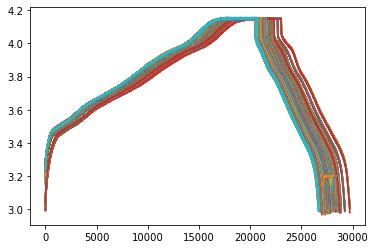

In [25]:
# all module check
df2 = df[df['mode'] != 'rest']

count = 0
for i in cycle_valid:
    if i not in err :
        df_test = df2[df2['cycle'] ==i]

        v1 = df_test['Cell_V01 [V]'].tolist()
        v2 = df_test['Cell_V02 [V]'].tolist()
        v3 = df_test['Cell_V03 [V]'].tolist()
        v4 = df_test['Cell_V04 [V]'].tolist()
        v5 = df_test['Cell_V05 [V]'].tolist()
        v6 = df_test['Cell_V06 [V]'].tolist()
        v7 = df_test['Cell_V07 [V]'].tolist()

        v8 = df_test['Cell_V08 [V]'].tolist()
        v9 = df_test['Cell_V09 [V]'].tolist()
        v10 = df_test['Cell_V10 [V]'].tolist()
        v11 = df_test['Cell_V11 [V]'].tolist()
        v12 = df_test['Cell_V12 [V]'].tolist()
        v13 = df_test['Cell_V13 [V]'].tolist()
        v14 = df_test['Cell_V14 [V]'].tolist()
        v_list = [v1, v2, v3,v4, v5, v6, v7, v8, v9, v10, 
                 v11, v12,v13,v14]

        t = [j for j in range(len(v1))]

        for k in v_list:
            plt.plot(t, k)

        count = count + 1

## 3. Pack data processing CNN

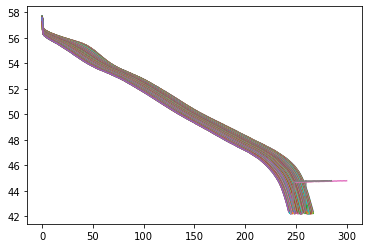

In [39]:
df2 = df[df['mode'] == 'discharge']
sum_I = []
count = 0
l = []
for i in cycle_valid:
    if i not in err :
        df_test = df2[df2['cycle'] ==i]
        l.append(len(df_test))
        #print(i)
        
        v = df_test['voltage [V]'].tolist()
        I = df_test['current [A]'].tolist()
        v2 = []
        I2 = []
        for filt in range(len(v)):
            if filt%25 == 0:
                v2.append(v[filt])
                I2.append(I[filt])
        t = [j for j in range(len(v2))]
        plt.plot(t, v2)
        sum_I.append(sum(I))

        count = count + 1


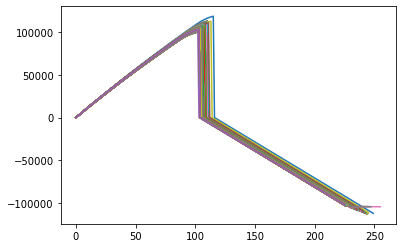

In [40]:
scaler = MinMaxScaler()

df_1 = df[df['mode'] == 'charge']
df_2 = df[df['mode'] == 'discharge']

sum_I_list = []
output_list = []
cycle_list = []
for i in cycle_valid:
    if i not in err:
        df_cha = df_1[df_1['cycle'] == i]
        df_dis = df_2[df_2['cycle'] == i]
        
        v_cha = df_cha['voltage [V]'].tolist()
        v_dis = df_dis['voltage [V]'].tolist()
        I_cha = df_cha['current [A]'].tolist()
        I_dis = df_dis['current [A]'].tolist()
        
        d_soh = df_dis[df_dis['voltage [V]'] >3.1*14]
        I_dis2 = d_soh['current [A]'].tolist()
        
        q0 = 0
        q_cha = []
        for k in I_cha:
            q0 = q0 + k
            q_cha.append(q0)

        q0 = 0
        q_dis = []
        for k in I_dis:
            q0 = q0 + k
            q_dis.append(q0)
            
        
        v_cha_filt, v_dis_filt, I_cha_filt, I_dis_filt, q_cha_filt, q_dis_filt = [],[],[],[],[],[]
        for filt in range(len(v_cha)):
            if filt % 200 == 0:
                v_cha_filt.append(v_cha[filt])
                I_cha_filt.append(I_cha[filt])
                q_cha_filt.append(q_cha[filt])
        for filt in range(len(v_dis)):
            if filt % 50 == 0:
                v_dis_filt.append(v_dis[filt])
                I_dis_filt.append(I_dis[filt])
                q_dis_filt.append(q_dis[filt])        
                
        v = v_cha_filt + v_dis_filt
        I = I_cha_filt + I_dis_filt
        q = q_cha_filt + q_dis_filt
        
        v_cha2 = scaler.fit_transform(np.array(v).reshape(-1,1)).reshape(1,-1).tolist()[0]
        I_cha2 = scaler.fit_transform(np.array(I).reshape(-1,1)).reshape(1,-1).tolist()[0]
        q_cha2 = scaler.fit_transform(np.array(q).reshape(-1,1)).reshape(1,-1).tolist()[0]
        
        v_cha2 = pad_sequences(np.array([v_cha2]), maxlen = 256, padding='post', dtype = 'float32').tolist()[0]
        I_cha2 = pad_sequences(np.array([I_cha2]), maxlen = 256, padding='post', dtype = 'float32').tolist()[0]
        q_cha2 = pad_sequences(np.array([q_cha2]), maxlen = 256, padding='post', dtype = 'float32').tolist()[0]
        
        plt.plot(q)
        output = [[int(v_cha2[cnt]*255), int(I_cha2[cnt]*255), int(q_cha2[cnt]*255)] for cnt in range(len(v_cha2))]

        output_list.append(output)
        
        sum_I_list.append(sum(I_dis)) 
        cycle_list.append(i)


In [41]:
soh = [i/sum_I_list[0] for i in sum_I_list]

In [42]:
d_pack = pd.DataFrame({})

d_pack['resized_scaled'] = output_list
d_pack['sum(I)'] = sum_I_list
d_pack['soh'] = soh
d_pack['#cycle'] = cycle_list
d_pack

,resized_scaled,sum(I),soh,#cycle
0,"[[0, 255, 123], [43, 250, 125], [63, 248, 126]...",-113094.9,1.000000,15
1,"[[36, 237, 129], [67, 255, 130], [80, 253, 131...",-113597.5,1.004444,16
2,"[[35, 206, 126], [67, 255, 128], [80, 253, 129...",-112892.1,0.998207,17
3,"[[38, 247, 129], [69, 255, 130], [82, 253, 131...",-113446.7,1.003111,18
4,"[[38, 253, 129], [69, 255, 130], [83, 253, 131...",-113352.1,1.002274,19
...,...,...,...,...
170,"[[42, 190, 126], [76, 255, 127], [88, 255, 129...",-102772.0,0.908724,328
171,"[[42, 236, 126], [75, 255, 127], [89, 252, 129...",-102751.3,0.908541,329
172,"[[43, 255, 126], [76, 252, 128], [89, 250, 129...",-102769.7,0.908703,330
173,"[[43, 232, 126], [76, 255, 128], [89, 252, 129...",-102937.7,0.910189,331


In [43]:
#d_pack.to_csv('//home/sbml/cgan/230306_data/padding/pack_preprocessed.csv')

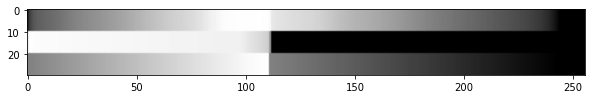

In [44]:
# for figure2
plt.figure(figsize = (10,10))
target = np.array(output_list[1])
v = [target[:,0].tolist()]*10
I = [target[:,1].tolist()]*10
q = [target[:,2].tolist()]*10
tar = np.array(v + I + q)
plt.imshow(tar, cmap = 'gray')
#plt.savefig('/home/sbml/cgan/230306_data/figure/fig1_result/for_cnn.svg')

## 4. Module data processing for cgan 

In [34]:
# all module check
scaler = MinMaxScaler()

df_1 = df[df['mode'] == 'charge'] 
df_2 = df[df['mode'] == 'discharge']
       
count = 0
pos_list, q_list, v_list, v2_list, cell_list, soh_list, cycle_list, cgan_list = [],[],[],[],[],[],[],[]

for i in cycle_valid:
    if i not in err :
        df_cha = df_1[df_1['cycle'] == i]
        df_dis = df_2[df_2['cycle'] == i]
        
        # for soh calculation
        col = df_cha.columns[5:19].tolist()
        
        # for database
        output_list = []
        for column in col:        
            v_cha = df_cha[column].tolist()
            v_dis = df_dis[column].tolist()
            I_cha = df_cha['current [A]'].tolist()
            I_dis = df_dis['current [A]'].tolist()  
            
            q0 = 0
            q_cha = []
            for k in I_cha:
                q0 = q0 + k
                q_cha.append(q0) 
                
            q0 = 0
            q_dis = []
            for k in I_dis:
                q0 = q0 + k
                q_dis.append(q0)
                
            v_cha_filt, v_dis_filt, I_cha_filt, I_dis_filt, q_cha_filt, q_dis_filt = [],[],[],[],[],[]
            

            for filt in range(len(v_cha)):
                if filt % 200 == 0:
                    v_cha_filt.append(v_cha[filt])
                    I_cha_filt.append(I_cha[filt])
                    q_cha_filt.append(q_cha[filt])
                    
            for filt in range(len(v_dis)):
                if filt % 50 == 0:
                    v_dis_filt.append(v_dis[filt])
                    I_dis_filt.append(I_dis[filt])
                    q_dis_filt.append(q_dis[filt])     
                    
            v = v_cha_filt + v_dis_filt
            I = I_cha_filt + I_dis_filt
            q = q_cha_filt + q_dis_filt
            
       

            v_cha2 = scaler.fit_transform(np.array(v).reshape(-1,1)).reshape(1,-1).tolist()[0]
            I_cha2 = scaler.fit_transform(np.array(I).reshape(-1,1)).reshape(1,-1).tolist()[0]
            q_cha2 = scaler.fit_transform(np.array(q).reshape(-1,1)).reshape(1,-1).tolist()[0]    

            v_cha2 = pad_sequences(np.array([v_cha2]), maxlen = 256, padding='post', dtype = 'float32').tolist()[0]
            I_cha2 = pad_sequences(np.array([I_cha2]), maxlen = 256, padding='post', dtype = 'float32').tolist()[0]
            q_cha2 = pad_sequences(np.array([q_cha2]), maxlen = 256, padding='post', dtype = 'float32').tolist()[0]
            
            
            output = [[int(v_cha2[cnt]*255), int(I_cha2[cnt]*255), int(q_cha2[cnt]*255)] for cnt in range(len(v_cha2))]
            
            output_list.append(output)
        cgan_list.append(output_list)
        

In [37]:
target = np.array(cgan_list[1])
target.shape

(14, 256, 3)

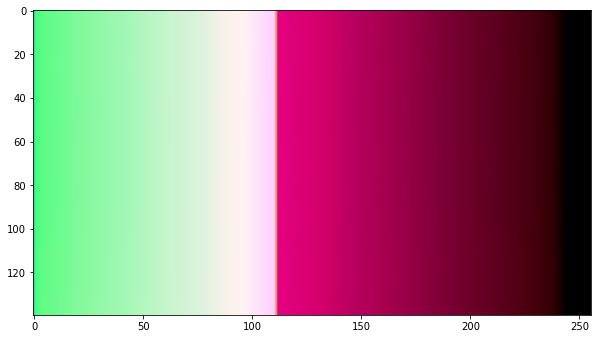

In [38]:
# for figure2
plt.figure(figsize = (10,10))
target = np.array(cgan_list[1])
tar = []
for i in range(14): 
    v = [target[i]]*10 #[:,i].tolist()]*10
    tar = tar + v
tar = np.array(tar)
plt.imshow(tar)
#plt.savefig('/home/sbml/cgan/230306_data/figure/fig1_result/for_cgan.svg')